In [9]:
import itertools
import numpy as np
import gym
np.random.seed(0)
env = gym.make('MountainCar-v0')
env.seed(0)

[0]

In [10]:
class Agent:
    def decide(self, observation):
        position, velocity = observation
        lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
                0.3 * (position + 0.9) ** 4 - 0.008)
        ub = -0.07 * (position + 0.38) ** 2 + 0.07
        if lb < velocity < ub:
            action = 2 # push right
        else:
            action = 0 # push left
        return action

agent = Agent()

In [16]:
def play_once(env, agent, render=False, verbose=False):
    observation = env.reset()
    episode_reward = 0.
    for step in itertools.count():
        if render:
            env.render()
        action = agent.decide(observation)
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    if verbose:
        print('get {} rewards in {} steps'.format(
                episode_reward, step + 1))
    return episode_reward

In [17]:
play_once(env, agent, render = True, verbose= True)
env.close()

get -105.0 rewards in 105 steps


In [6]:

episode_rewards = [play_once(env, agent) for _ in range(100)]
print('average episode rewards = {}'.format(np.mean(episode_rewards)))

average episode rewards = -104.02


In [7]:

episode_rewards = [play_once(env, agent) for _ in range(1000)]
print('average episode rewards = {}'.format(np.mean(episode_rewards)))

average episode rewards = -105.535


In [8]:
env.close()

In [18]:
#after this cell this is SARSA

In [19]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

In [20]:
class TileCoder:
    def __init__(self, layers, features):
        """ 
        Parameters
        - layers: int, the number of layers in tile coding
        - features: int, the number of features, also the shape of weights
        """
        self.layers = layers
        self.features = features
        self.codebook = {}
    
    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.features: # collide when codebook is full
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
        
    def __call__(self, floats=(), ints=()):
        """ 
        Parameters
        - floats: tuple of floats, each of which is within [0., 1.]
        - ints: tuple of ints
        Returns
        - features : list of ints
        """
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) / self.layers) \
                    for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [21]:
class SARSAAgent:
    def __init__(self, env, layers=8, features=2000, gamma=1.,
                learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - env.observation_space.low
        self.encoder = TileCoder(layers, features)
        self.w = np.zeros(features)
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action):
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in range(self.action_n)]
            return np.argmax(qs)
        
    def learn(self, observation, action, reward, observation_next, done, action_next=None):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(observation_next, action_next))
        delta = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * delta)


class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, layers=8, features=2000, gamma=1.,
                learning_rate=0.03, epsilon=0.001, lambd=0.9):
        super().__init__(env=env, layers=layers, features=features,
                gamma=gamma, learning_rate=learning_rate, epsilon=epsilon)
        self.lambd = lambd
        self.z = np.zeros(features)
        
    def learn(self, observation, action, reward, observation_next, done, action_next=None):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(observation_next, action_next))
            self.z *= (self.gamma * self.lambd)
            features = self.encode(observation, action)
            self.z[features] = 1. # replacement trace
        delta = u - self.get_q(observation, action)
        self.w += (self.learning_rate * delta * self.z)
        if done:
            self.z = np.zeros_like(self.z)

In [22]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        observation_next, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            if train:
                agent.learn(observation, action, reward, observation_next, done)
            break
        action_next = agent.decide(observation_next)
        if train:
            agent.learn(observation, action, reward, observation_next, done, action_next)
        observation, action = observation_next, action_next
    return episode_reward

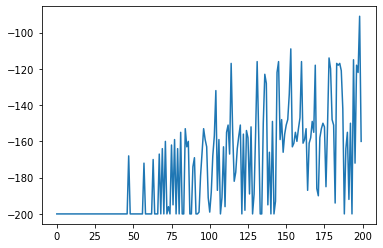

In [33]:
env = gym.make('MountainCar-v0')
env.seed(0)
#env = gym.wrappers.Monitor(env, "./records", video_callable=lambda _:True)
agent = SARSAAgent(env)
#agent = SARSALambdaAgent(env)  

episodes = 200
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

In [30]:
env.close()

In [34]:
play_sarsa(env, agent, train=False, render=True)
env.close()